In [1]:
import sys, os, distutils.core
sys.path.insert(0, os.path.abspath('../../../detectron2'))
sys.path.insert(0, os.path.abspath('../../../'))
sys.path.insert(0, os.path.abspath('.'))
os.environ['DETECTRON2_DATASETS'] = '/home/liwa/data/datasets/'

from detectron2.data import DatasetCatalog, MetadataCatalog
from oneformer.data.datasets.register_yeast_panoptic_annos_semseg import register_all_yeast_panoptic_annos_sem_seg
from tqdm import trange
import pickle

from skimage.morphology import disk, remove_small_objects, opening, closing, erosion, remove_small_holes


ModuleNotFoundError: No module named 'detectron2'

In [2]:
from detectron2.config import get_cfg
from detectron2.projects.panoptic_deeplab import (
    PanopticDeeplabDatasetMapper,
    add_panoptic_deeplab_config,
)
from detectron2.engine import default_setup
from detectron2.engine import DefaultPredictor
from prediction import Predictor
from google.colab.patches import cv2_imshow
import os, json, cv2, random
from detectron2.utils.visualizer import Visualizer
import torch

In [3]:
torch.get_num_threads()
torch.set_num_threads(2)

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:8700m"
cfg = get_cfg()
add_panoptic_deeplab_config(cfg)
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file("/home/liwa/data/oneformer_output/output/config.yaml")

cfg.MODEL.DEVICE = "cuda"
# into cpu model
cfg.MODEL.SEM_SEG_HEAD.NORM = "BN"
cfg.MODEL.INS_EMBED_HEAD.NORM = "BN"
cfg.MODEL.RESNETS.NORM = "BN"
cfg.MODEL.PANOPTIC_DEEPLAB.TOP_K_INSTANCE = None
cfg.MODEL.PANOPTIC_DEEPLAB.INSTANCE_AREA_THRESHOLD = 3000
# cfg.MODEL.PANOPTIC_DEEPLAB.CENTER_THRESHOLD = 0.1
# cfg.MODEL.PANOPTIC_DEEPLAB.PREDICT_INSTANCES = False
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = os.path.abspath("/home/liwa/data/oneformer_output/output/model_0059999.pth")
# cfg.MODEL.WEIGHTS = os.path.abspath("/home/liwa/data/Oneformer_model/test_save_model.pth")
# cfg.MODEL.WEIGHTS = "detectron2://DeepLab/R-52.pkl"
# cfg.INPUT.MIN_SIZE_TEST = 512
# cfg.INPUT.MAX_SIZE_TRAIN = 2048


# torch.save(model.state_dict(), "model.pth")
# torch.save(predictor.model.state_dict(), "/home/liwa/data/Oneformer_model/test_save_model.pth")

In [5]:
predictor = Predictor(cfg)
# predictor.model = predictor.model.half()
predictor.cfg

CfgNode({'VERSION': 2, 'MODEL': CfgNode({'LOAD_PROPOSALS': False, 'MASK_ON': False, 'KEYPOINT_ON': False, 'DEVICE': 'cuda', 'META_ARCHITECTURE': 'PanopticDeepLab', 'WEIGHTS': '/home/liwa/data/oneformer_output/output/model_0059999.pth', 'PIXEL_MEAN': [102.364, 102.364, 102.364], 'PIXEL_STD': [23.532, 23.532, 23.532], 'BACKBONE': CfgNode({'NAME': 'build_resnet_deeplab_backbone', 'FREEZE_AT': 0}), 'FPN': CfgNode({'IN_FEATURES': [], 'OUT_CHANNELS': 256, 'NORM': '', 'FUSE_TYPE': 'sum'}), 'PROPOSAL_GENERATOR': CfgNode({'NAME': 'RPN', 'MIN_SIZE': 0}), 'ANCHOR_GENERATOR': CfgNode({'NAME': 'DefaultAnchorGenerator', 'SIZES': [[32, 64, 128, 256, 512]], 'ASPECT_RATIOS': [[0.5, 1.0, 2.0]], 'ANGLES': [[-90, 0, 90]], 'OFFSET': 0.0}), 'RPN': CfgNode({'HEAD_NAME': 'StandardRPNHead', 'IN_FEATURES': ['res4'], 'BOUNDARY_THRESH': -1, 'IOU_THRESHOLDS': [0.3, 0.7], 'IOU_LABELS': [0, -1, 1], 'BATCH_SIZE_PER_IMAGE': 256, 'POSITIVE_FRACTION': 0.5, 'BBOX_REG_LOSS_TYPE': 'smooth_l1', 'BBOX_REG_LOSS_WEIGHT': 1.0, 

In [6]:
from pathlib import Path
from skimage.io import imread, imsave
import numpy as np

movie_path_list = list(Path("/home/liwa/data/mating_data/20250624_ywl065/").rglob("*_rigid.tif"))
movie_path_list = [str(x) for x in movie_path_list]
movie_path_list.sort()

In [7]:
movie_path_list

['/home/liwa/data/mating_data/20250624_ywl065/1_rigid/01_ywl065-06_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/02_ywl065-07_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/03_ywl065-10_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/04_ywl065-08_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/05_ywl065-09_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/06_ywl065-03_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/07_ywl065-02_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/08_ywl065-01_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/09_ywl065-04_rigid.tif',
 '/home/liwa/data/mating_data/20250624_ywl065/1_rigid/10_ywl065-05_rigid.tif']

In [8]:
DIVISION = 1000
min_box = 0
max_box = 1300
crops = [[0, max_box ,0,max_box], [0, max_box ,2048-max_box,2048], [2048-max_box,2048,0,max_box], [2048-max_box,2048,2048-max_box,2048]]
score_threshold = 0.7

def self_defined_post_process(prediction_output):
    panoptic_seg, _ = prediction_output["panoptic_seg"]
    panoptic_seg[panoptic_seg<DIVISION] = 0
    panoptic_seg = panoptic_seg.cpu().numpy()
    panopitc_labels = np.unique(panoptic_seg)
    panopitc_labels = panopitc_labels[panopitc_labels>DIVISION]

    instances = prediction_output["instances"]
    scores = list(instances.center_scores.to("cpu"))
    bboxes = instances.pred_boxes.to("cpu")
    del instances

    segments_info= []
    if len(panopitc_labels) == len(scores):
        for in_x, panoptic_label in enumerate(panopitc_labels):
            a ,b, c, d = bboxes[in_x].tensor[0]
            if (a == min_box) | (b == min_box) | (c == max_box) | (d == max_box) | (scores[in_x] < score_threshold):
                panoptic_seg[panoptic_seg==panoptic_label] = 0
                continue

            segments_info.append(
                {
                    "id": int(panoptic_label),
                    "category_id": int(panoptic_label // DIVISION),
                    "isthing": True,
                    "score": float(scores[in_x]),
                }
            )
    return panoptic_seg, segments_info

In [10]:
for movie_path in movie_path_list[1:2]:
    print(movie_path)
    movie = imread(movie_path)[:,0]
    for idx, (c1, c2, c3, c4) in enumerate(crops):
        cropped_movie = movie[:, c1:c2, c3:c4]
        segment_movie = np.zeros(cropped_movie.shape, dtype=np.uint16)
        segments_info_movie = []

        for frame in trange(0, cropped_movie.shape[0]):
            try:
                image = cropped_movie[frame,:,:]
                image = image - image.min()
                image = image / image.max()
                image = (image * 255).astype(np.uint8)
                im = np.stack((image,)*3, axis=-1)
                prediction_output = predictor(im)
                panoptic_seg, segments_info = self_defined_post_process(prediction_output)
                                                
                segment_movie[frame] = np.array(panoptic_seg,  dtype=np.uint16)
                segments_info_movie.append(segments_info)
                
                del prediction_output, panoptic_seg, segments_info, image, im
            except Exception as e:
                print("Error occurred:", e)
                continue

        imsave(movie_path[:-4]+f"_crop_{idx}_mask.tif", segment_movie)
        with open(movie_path[:-4]+f"_crop_{idx}_segment_info.pkl", "wb") as f:
            pickle.dump(segments_info_movie, f)
        del cropped_movie, segment_movie, segments_info_movie
    del movie

/home/liwa/data/mating_data/20250624_ywl065/1_rigid/02_ywl065-07_rigid.tif


 24%|████████████████████████████████▌                                                                                                        | 43/181 [02:54<07:30,  3.27s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.48 GiB (GPU 0; 10.91 GiB total capacity; 5.20 GiB already allocated; 1.48 GiB free; 5.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 22%|██████████████████████████████▎                                                                                                          | 40/181 [02:40<07:33,  3.21s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.51 GiB (GPU 0; 10.91 GiB total capacity; 5.30 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 23%|███████████████████████████████                                                                                                          | 41/181 [02:40<05:35,  2.40s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.07 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 23%|███████████████████████████████▊                                                                                                         | 42/181 [02:41<04:12,  1.82s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.50 GiB (GPU 0; 10.91 GiB total capacity; 5.26 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 24%|████████████████████████████████▌                                                                                                        | 43/181 [02:41<03:14,  1.41s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.49 GiB (GPU 0; 10.91 GiB total capacity; 5.22 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 24%|█████████████████████████████████▎                                                                                                       | 44/181 [02:42<02:34,  1.13s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.47 GiB (GPU 0; 10.91 GiB total capacity; 5.17 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 25%|██████████████████████████████████                                                                                                       | 45/181 [02:42<02:06,  1.08it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.47 GiB (GPU 0; 10.91 GiB total capacity; 5.18 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 25%|██████████████████████████████████▊                                                                                                      | 46/181 [02:43<01:46,  1.27it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.09 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 26%|███████████████████████████████████▌                                                                                                     | 47/181 [02:43<01:32,  1.45it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.43 GiB (GPU 0; 10.91 GiB total capacity; 5.05 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 27%|████████████████████████████████████▎                                                                                                    | 48/181 [02:44<01:22,  1.61it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.46 GiB (GPU 0; 10.91 GiB total capacity; 5.15 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 27%|█████████████████████████████████████                                                                                                    | 49/181 [02:44<01:15,  1.74it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.45 GiB (GPU 0; 10.91 GiB total capacity; 5.11 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 28%|█████████████████████████████████████▊                                                                                                   | 50/181 [02:45<01:10,  1.85it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.49 GiB (GPU 0; 10.91 GiB total capacity; 5.22 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 28%|██████████████████████████████████████▌                                                                                                  | 51/181 [02:45<01:07,  1.92it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.47 GiB (GPU 0; 10.91 GiB total capacity; 5.17 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 29%|███████████████████████████████████████▎                                                                                                 | 52/181 [02:46<01:05,  1.97it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.45 GiB (GPU 0; 10.91 GiB total capacity; 5.11 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 29%|████████████████████████████████████████                                                                                                 | 53/181 [02:46<01:03,  2.03it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.45 GiB (GPU 0; 10.91 GiB total capacity; 5.11 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 30%|████████████████████████████████████████▊                                                                                                | 54/181 [02:47<01:01,  2.06it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.07 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 30%|█████████████████████████████████████████▋                                                                                               | 55/181 [02:47<01:00,  2.10it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.09 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 31%|██████████████████████████████████████████▍                                                                                              | 56/181 [02:47<00:59,  2.11it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.09 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 31%|███████████████████████████████████████████▏                                                                                             | 57/181 [02:48<00:58,  2.12it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.47 GiB (GPU 0; 10.91 GiB total capacity; 5.17 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 32%|███████████████████████████████████████████▉                                                                                             | 58/181 [02:48<00:57,  2.14it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.41 GiB (GPU 0; 10.91 GiB total capacity; 5.00 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 33%|████████████████████████████████████████████▋                                                                                            | 59/181 [02:49<00:56,  2.15it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.09 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 33%|█████████████████████████████████████████████▍                                                                                           | 60/181 [02:49<00:56,  2.14it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.45 GiB (GPU 0; 10.91 GiB total capacity; 5.11 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 34%|██████████████████████████████████████████████▏                                                                                          | 61/181 [02:50<00:55,  2.14it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.09 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 34%|██████████████████████████████████████████████▉                                                                                          | 62/181 [02:50<00:55,  2.15it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.09 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 35%|███████████████████████████████████████████████▋                                                                                         | 63/181 [02:51<00:55,  2.14it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.45 GiB (GPU 0; 10.91 GiB total capacity; 5.11 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 35%|████████████████████████████████████████████████▍                                                                                        | 64/181 [02:51<00:54,  2.16it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.42 GiB (GPU 0; 10.91 GiB total capacity; 5.02 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 36%|█████████████████████████████████████████████████▏                                                                                       | 65/181 [02:52<00:53,  2.16it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.42 GiB (GPU 0; 10.91 GiB total capacity; 5.03 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 37%|██████████████████████████████████████████████████▋                                                                                      | 67/181 [02:56<02:27,  1.29s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.39 GiB (GPU 0; 10.91 GiB total capacity; 4.94 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 38%|███████████████████████████████████████████████████▍                                                                                     | 68/181 [02:57<01:57,  1.04s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.41 GiB (GPU 0; 10.91 GiB total capacity; 5.00 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 38%|████████████████████████████████████████████████████▏                                                                                    | 69/181 [02:57<01:37,  1.15it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.39 GiB (GPU 0; 10.91 GiB total capacity; 4.92 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 39%|████████████████████████████████████████████████████▉                                                                                    | 70/181 [02:58<01:23,  1.33it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.39 GiB (GPU 0; 10.91 GiB total capacity; 4.92 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 39%|█████████████████████████████████████████████████████▋                                                                                   | 71/181 [02:58<01:12,  1.51it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.41 GiB (GPU 0; 10.91 GiB total capacity; 5.00 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 40%|███████████████████████████████████████████████████████▎                                                                                 | 73/181 [03:03<02:29,  1.39s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.40 GiB (GPU 0; 10.91 GiB total capacity; 4.96 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 41%|████████████████████████████████████████████████████████                                                                                 | 74/181 [03:04<01:59,  1.11s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.41 GiB (GPU 0; 10.91 GiB total capacity; 5.00 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 41%|████████████████████████████████████████████████████████▊                                                                                | 75/181 [03:04<01:37,  1.09it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.39 GiB (GPU 0; 10.91 GiB total capacity; 4.94 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 42%|█████████████████████████████████████████████████████████▌                                                                               | 76/181 [03:05<01:22,  1.27it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.42 GiB (GPU 0; 10.91 GiB total capacity; 5.02 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 43%|██████████████████████████████████████████████████████████▎                                                                              | 77/181 [03:05<01:11,  1.45it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.42 GiB (GPU 0; 10.91 GiB total capacity; 5.03 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 43%|███████████████████████████████████████████████████████████                                                                              | 78/181 [03:06<01:04,  1.61it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.40 GiB (GPU 0; 10.91 GiB total capacity; 4.98 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 44%|███████████████████████████████████████████████████████████▊                                                                             | 79/181 [03:06<00:58,  1.74it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.40 GiB (GPU 0; 10.91 GiB total capacity; 4.98 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 44%|████████████████████████████████████████████████████████████▌                                                                            | 80/181 [03:06<00:54,  1.84it/s]

Error occurred: CUDA out of memory. Tried to allocate 1.44 GiB (GPU 0; 10.91 GiB total capacity; 5.09 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 45%|██████████████████████████████████████████████████████████████                                                                           | 82/181 [03:11<02:09,  1.31s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.41 GiB (GPU 0; 10.91 GiB total capacity; 5.00 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


 46%|██████████████████████████████████████████████████████████████▊                                                                          | 83/181 [03:12<01:43,  1.06s/it]

Error occurred: CUDA out of memory. Tried to allocate 1.39 GiB (GPU 0; 10.91 GiB total capacity; 4.94 GiB already allocated; 1.38 GiB free; 5.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 181/181 [11:17<00:00,  3.74s/it]


## test

In [14]:
im = imread(movie_path_list[1])[42, 0, 0:1300, 0:1300]
# segment_movie = np.zeros(movie.shape[:3], dtype=np.uint16)
# for frame in trange(0, movie.shape[0]):
#     image = movie[frame,:,:,0]
im = im - im.min()
im = im / im.max()
im = (im * 255).astype(np.uint8)
im = np.stack((im,)*3, axis=-1)

print(im.shape)

(1300, 1300, 3)


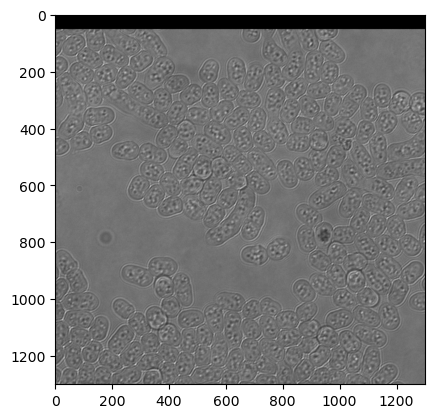

In [15]:
import matplotlib.pyplot as plt
plt.imshow(im)

In [16]:
with torch.no_grad():
    prediction_output = predictor(im)
    print(prediction_output.keys()) 

RuntimeError: CUDA out of memory. Tried to allocate 1.48 GiB (GPU 0; 10.91 GiB total capacity; 5.59 GiB already allocated; 79.69 MiB free; 6.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [50]:
panoptic_seg, _ = prediction_output["panoptic_seg"]
panopitc_labels = np.unique(panoptic_seg.to("cpu").numpy())
panopitc_labels = panopitc_labels[panopitc_labels>1000]
instances = prediction_output["instances"]
scores = list(instances.center_scores.to("cpu"))
bboxes = instances.pred_boxes.to("cpu")

segments_info = []
if len(panopitc_labels) == len(scores):
    for idx, panoptic_label in enumerate(panopitc_labels):
        a ,b, c, d = bboxes[idx].tensor[0]
        if (a == 0) | (b == 0) | (c == 1300) | (d == 1300) | (scores[idx] < 0.6):
            panoptic_seg[panoptic_seg==panoptic_label] = -1
            continue
        
        segments_info.append(
            {
                "id": int(panoptic_label),
                "category_id": int(panoptic_label // 1000),
                "isthing": True,
                "score": float(scores[idx]),
            }
        )
        

In [51]:
segments_info

[{'id': 1001, 'category_id': 1, 'isthing': True, 'score': 0.9473673105239868},
 {'id': 1002, 'category_id': 1, 'isthing': True, 'score': 1.0015537738800049},
 {'id': 1003, 'category_id': 1, 'isthing': True, 'score': 0.974581241607666},
 {'id': 1004, 'category_id': 1, 'isthing': True, 'score': 0.9946869015693665},
 {'id': 1005, 'category_id': 1, 'isthing': True, 'score': 0.9140133261680603},
 {'id': 1006, 'category_id': 1, 'isthing': True, 'score': 0.9575968980789185},
 {'id': 1007, 'category_id': 1, 'isthing': True, 'score': 0.9873117208480835},
 {'id': 1008, 'category_id': 1, 'isthing': True, 'score': 0.9738907814025879},
 {'id': 1009, 'category_id': 1, 'isthing': True, 'score': 0.9833471179008484},
 {'id': 1010, 'category_id': 1, 'isthing': True, 'score': 0.9874386191368103},
 {'id': 1011, 'category_id': 1, 'isthing': True, 'score': 0.9720540046691895},
 {'id': 1012, 'category_id': 1, 'isthing': True, 'score': 0.9435716271400452},
 {'id': 1013, 'category_id': 1, 'isthing': True, 'sco

{1001: {'id': 1001, 'category_id': 1, 'isthing': True, 'score': 0.9473673105239868}, 1002: {'id': 1002, 'category_id': 1, 'isthing': True, 'score': 1.0015537738800049}, 1003: {'id': 1003, 'category_id': 1, 'isthing': True, 'score': 0.974581241607666}, 1004: {'id': 1004, 'category_id': 1, 'isthing': True, 'score': 0.9946869015693665}, 1005: {'id': 1005, 'category_id': 1, 'isthing': True, 'score': 0.9140133261680603}, 1006: {'id': 1006, 'category_id': 1, 'isthing': True, 'score': 0.9575968980789185}, 1007: {'id': 1007, 'category_id': 1, 'isthing': True, 'score': 0.9873117208480835}, 1008: {'id': 1008, 'category_id': 1, 'isthing': True, 'score': 0.9738907814025879}, 1009: {'id': 1009, 'category_id': 1, 'isthing': True, 'score': 0.9833471179008484}, 1010: {'id': 1010, 'category_id': 1, 'isthing': True, 'score': 0.9874386191368103}, 1011: {'id': 1011, 'category_id': 1, 'isthing': True, 'score': 0.9720540046691895}, 1012: {'id': 1012, 'category_id': 1, 'isthing': True, 'score': 0.94357162714

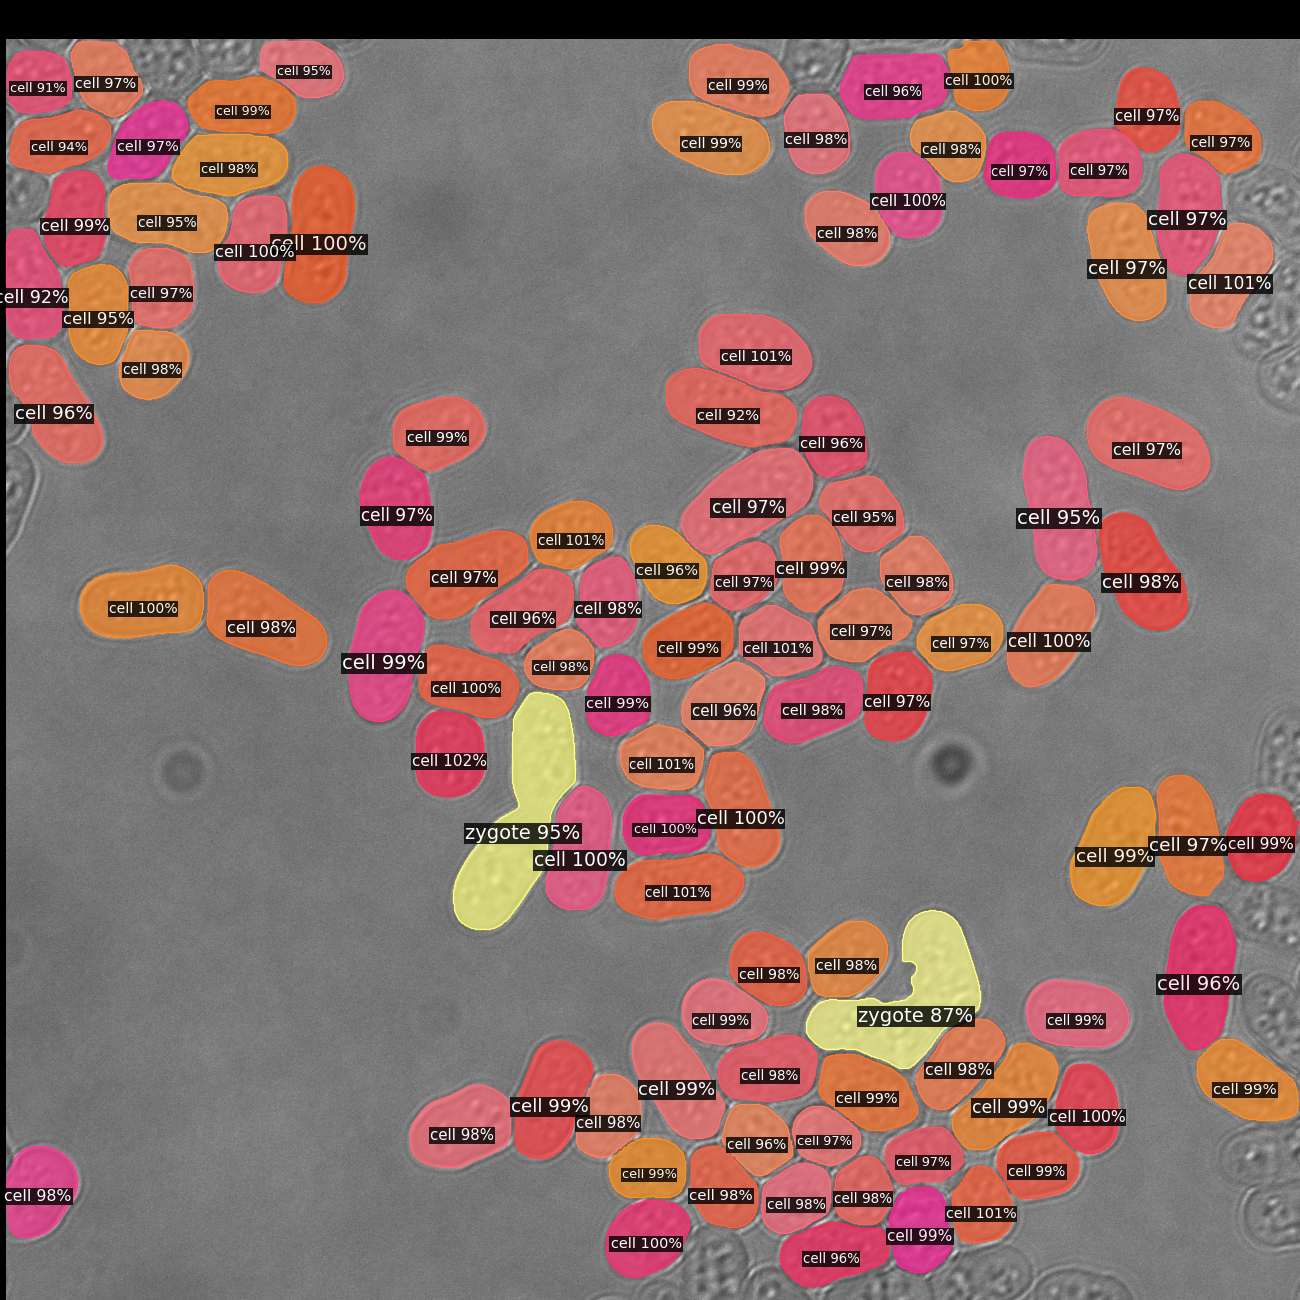

In [37]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg(panoptic_seg.to("cpu"), segments_info)

cv2_imshow(out.get_image()[:, :, ::-1])